# Analyzing CPS NTIA Survey data

## Data and ReferencesSources

* Data: https://www.ntia.doc.gov/page/download-digital-nation-datasets
* Map (useful for checks!): https://www.ntia.doc.gov/data/digital-nation-data-explorer#sel=internetAtHome&disp=map
* Docs: https://www.ntia.doc.gov/files/ntia/publications/november-2019-techdocs.pdf
* Universes: https://www.ntia.doc.gov/files/ntia/data_central_downloads/code/create-ntia-tables-stata.zip

For this notebook to work, the following two datasets must be downloaded to this directory.

* Raw data: https://www.ntia.doc.gov/files/ntia/data_central_downloads/datasets/nov19-cps-csv.zip
* Processed data: https://www.ntia.doc.gov/files/ntia/publications/ntia-analyze-table_2020-05-15.csv

### Useful variables:

peinhome, peinwork, pemphone, pemphone, hemobdat, hehomte1, hefaminc, pesex, prtage, peeduca, ptdtrace, prdthsp, prnmchld, gestfips

In [1]:
import pandas
import requests

# Construct a dictionary for FIPS to state name.
resp = requests.get("https://api.census.gov/data/2019/acs/acs5/profile?get=NAME&for=state:*")
fips = {int(v[1]) : v[0] for v in resp.json()[1:]}

## Constructed variables of Internet Access

For reference, see the stata code by Rafi Goldberg, <rgoldberg@ntia.doc.gov>

In [2]:
cps = pd.read_csv("nov19-cps.csv.gz")
#cps.query("pwsswgt > 0")

# We can get these later for standard errors...
# cps = cps.filter(regex = "^((?!wgt[0-9]).)*$", axis = 1)

## Demographics 
ed_map = {-1 : "", 31 : "No Diploma", 32 : "No Diploma", 33 : "No Diploma", 34 : "No Diploma",
          35 : "No Diploma", 36 : "No Diploma", 37 : "No Diploma", 38 : "No Diploma",
          39 : "High School", 40 : "Some College or Associates", 41 : "Some College or Associates", 42 : "Some College or Associates",
          43 : "College or Higher", 44 : "College or Higher", 45 : "College or Higher", 46 : "College or Higher"}

cps["education"] = cps.peeduca.replace(ed_map)

## Construct all the universe, following their cuts.
cps["isPerson"]      = (cps.prtage >= 3) & (cps.prpertyp != 3)
cps["isHouseholder"] = (cps.perrp > 0) & (cps.perrp < 3) & (cps.hrhtype > 0) & (cps.hrhtype < 9)
cps["isAdult"]       = cps.isPerson & (cps.prtage >= 15)
cps["isRespondent"]  = cps.puelgflg == 20

cps["notGQ"]         = cps.hrhtype.isin([1, 2, 3, 4, 5, 6, 7, 8])

cps["P_at_home"]     = np.where(cps.isPerson, cps.peinhome == 1, np.nan)
cps["P_at_work"]     = np.where(cps.isPerson, cps.peinwork == 1, np.nan)
cps["P_at_school"]   = np.where(cps.isPerson, cps.peinschl == 1, np.nan)
cps["P_anywhere"]    = np.where(cps.isPerson, 
                                (cps.peinhome == 1) | (cps.peinwork == 1) | (cps.peinschl == 1) | \
                                (cps.peincafe == 1) | (cps.peintrav == 1) | (cps.peinlico == 1) | \
                                (cps.peinelho == 1) | (cps.peinothr == 1), 
                                np.nan)

cps["P_mobdat"]      = np.where(cps.isPerson, cps.hemobdat == 1, np.nan)

cps["P_computer"]    = np.where(cps.isPerson, (cps.pelaptop == 1) | (cps.pedesktp == 1), np.nan)
cps["P_smartphone"]  = np.where(cps.isPerson, cps.pemphone == 1, np.nan)

cps["P_email"]       = np.where(cps.isPerson, cps.peemail == 1, np.nan)
cps["P_text"]        = np.where(cps.isPerson, cps.petextim == 1, np.nan)
cps["P_social"]      = np.where(cps.isPerson, cps.pesocial == 1, np.nan)
cps["P_video"]       = np.where(cps.isPerson, cps.pevideo == 1, np.nan)
cps["P_services"]    = np.where(cps.isPerson, cps.peusesvc == 1, np.nan)
cps["P_confcall"]    = np.where(cps.isPerson, cps.peconfer == 1, np.nan)
cps["P_remote"]      = np.where(cps.isPerson, cps.petelewk == 1, np.nan)
cps["P_financ"]      = np.where(cps.isPerson, cps.pefinanc == 1, np.nan)


cps["H_at_home"]     = np.where(cps.isHouseholder, cps.heinhome == 1, np.nan)
cps["H_anywhere"]    = np.where(cps.isHouseholder, 
                                (cps.heinhome == 1) | (cps.heinwork == 1) | (cps.heinschl == 1) | \
                                (cps.heincafe == 1) | (cps.heintrav == 1) | (cps.heinlico == 1) | \
                                (cps.heinelho == 1) | (cps.heinothr == 1), 
                                np.nan)

# Reaons for non-use.
cps["H_nonuse_cost"] = np.where(cps.isHouseholder, cps.heprinoh.isin([2, 3]), np.nan)
cps["H_nonuse_no_interest"] = np.where(cps.isHouseholder, cps.heprinoh == 1, np.nan)
cps["H_nonuse_not_available"] = np.where(cps.isHouseholder, cps.heprinoh == 5, np.nan)

cps["H_smartphone"]  = cps.hemphone == 1
cps["H_computer"]    = (cps.helaptop == 1) | (cps.hedesktp == 1)

## NTIA constructs these as high speed conditional on internet, 
##   which I think is less useful than the non-conditional ACS construction, 
##   but we can do this to get their numbers.
HIGH_SPEED_CONDITIONAL = False # False is better!  NTIA uses True.
if HIGH_SPEED_CONDITIONAL:
    cps["H_highsp"] = np.where(cps.isHouseholder & (cps.H_anywhere == True), cps.hehomte1 == 1, np.nan)
    cps["H_mobdat"] = np.where(cps.isHouseholder & (cps.H_at_home  == True), cps.hemobdat == 1, np.nan)
else:
    cps["H_highsp"] = np.where(cps.isHouseholder, cps.hehomte1 == 1, np.nan)
    cps["H_mobdat"] = np.where(cps.isHouseholder, cps.hemobdat == 1, np.nan)
    
cps["state"] = cps.gestfips.replace(fips)

Next, here are some functions for deriving weighted averages for any group, with the correct weights.

In [3]:
def weighted_mean(G, w): return G._get_numeric_data().multiply(G[w],  axis=0).sum()/G[w].sum()

def access(df, grouper, HH = True, person = True):
    
    out_data = []
    
    if HH:
        
        hwss_vars =  df.query("isHouseholder").groupby(grouper).apply(weighted_mean, w = "hwhhwgt")\
                       [["H_at_home", "H_mobdat", "H_highsp"]]

        hwss_vars_use =  df.query("isHouseholder & (H_at_home == False)")\
                           .groupby(grouper).apply(weighted_mean, w = "hwhhwgt")\
                           [["H_nonuse_cost", "H_nonuse_no_interest", "H_nonuse_not_available"]]
        
        out_data.extend([hwss_vars, hwss_vars_use])

    if person:
        
        counts = df.query("isPerson").groupby(grouper).agg({"pwsswgt" : ["sum", "count"]})
        counts.columns = ["cps_population", "N"]
        
        pwss_vars =  df.query("isPerson").groupby(grouper).apply(weighted_mean, w = "pwsswgt")\
                       [["P_anywhere", "P_at_home", "P_at_work", "P_smartphone", "P_computer"]] 

        pwpr_vars =  df.query("isRespondent").groupby(grouper).apply(weighted_mean, w = "pwprmwgt")\
                       [["P_email", "P_text", "P_confcall", "P_remote", 
                         "P_social", "P_video", "P_services", "P_financ"]]
        
        out_data.extend([counts, pwss_vars, pwpr_vars])
        
    complete = pd.concat(out_data, axis = 1).round(3)
        
    complete.index = complete.index.str.replace("_", " ").str.title()

    return complete.round(3)
    

## Defining Geographies

### Construct city and CBSA populations.

These must be defined based on a combination of state, CBSA (which can span states), whether or not the household is in the city, and the central city, and in certain cases, which county.  Read the documentation carefully for this.

In [4]:
cities = ["new_york", "los_angeles", "chicago", "houston", "phoenix",
          "philadelphia", "san_antonio", "san_diego", "dallas",
          "san_jose", "austin", "jacksonville", "san_francisco", "columbus",
          "fort_worth", "indianapolis", "charlotte", "seattle", "denver", "washington"]

city_dict = { # state, cbsa, city #
  "new_york"     : {"gestfips" : 36, "gtcbsa" : 35620, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "los_angeles"  : {"gestfips" :  6, "gtcbsa" : 31080, "gtcbsast" : 1, "gtindvpc" : 1, "gtco" :  37}, 
  "chicago"      : {"gestfips" : 17, "gtcbsa" : 16980, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "houston"      : {"gestfips" : 48, "gtcbsa" : 26420, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "phoenix"      : {"gestfips" :  4, "gtcbsa" : 38060, "gtcbsast" : 1, "gtindvpc" : 1},
  "philadelphia" : {"gestfips" : 42, "gtcbsa" : 37980, "gtcbsast" : 1, "gtindvpc" : 0, "gtco" : 101},
  "san_antonio"  : {"gestfips" : 48, "gtcbsa" : 41700, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "san_diego"    : {"gestfips" :  6, "gtcbsa" : 41740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "dallas"       : {"gestfips" : 48, "gtcbsa" : 19100, "gtcbsast" : 1, "gtindvpc" : 1},
  "san_jose"     : {"gestfips" :  6, "gtcbsa" : 41940, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "austin"       : {"gestfips" : 48, "gtcbsa" : 12420, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "jacksonville" : {"gestfips" : 12, "gtcbsa" : 27260, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "san_francisco": {"gestfips" :  6, "gtcbsa" : 41860, "gtcbsast" : 1, "gtindvpc" : 1, "gtco" :  75}, # SF county
  "columbus"     : {"gestfips" : 39, "gtcbsa" : 18140, "gtcbsast" : 1, "gtindvpc" : 0},
  "fort_worth"   : {"gestfips" : 48, "gtcbsa" : 19100, "gtcbsast" : 1, "gtindvpc" : 2}, 
  "indianapolis" : {"gestfips" : 18, "gtcbsa" : 26900, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "charlotte"    : {"gestfips" : 37, "gtcbsa" : 16740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "seattle"      : {"gestfips" : 53, "gtcbsa" : 42660, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "denver"       : {"gestfips" :  8, "gtcbsa" : 19740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "washington"   : {"gestfips" : 11, "gtcbsa" : 47900, "gtcbsast" : 1, "gtindvpc" : 1}
}

cps["city"] = ""
for city, vals in city_dict.items():
    
    query = " & ".join(["({} == {:})".format(k, v)
                        for k, v in vals.items()])
    
    cps.loc[cps.query(query).index, "city"] = city
    
cps_city = cps[cps.city != ""].copy()

CBSA's are much easier: a single field suffices.

In [5]:
cbsa = ["new_york", "los_angeles", "chicago", "dallas-fort_worth", "houston", 
        "philadelphia", "washington", "miami", "atlanta", "boston", 
        "san_francisco", "riverside", "phoenix", "detroit", "seattle", 
        "minneapolis", "san_diego", "tampa", "st_louis", "denver"]

cbsa_dict = {
    35620 : "new_york", 31080 : "los_angeles", 16980 : "chicago", 19100 : "dallas-fort_worth", 26420 : "houston", 
    37980 : "philadelphia", 47900 : "washington", 33100 : "miami", 12060 : "atlanta", 14460 : "boston", 
    41860 : "san_francisco", 40140 : "riverside", 38060 : "phoenix", 19820 : "detroit", 42660 : "seattle", 
    33460 : "minneapolis", 41740 : "san_diego", 45300 : "tampa", 41180 : "st_louis", 19740 : "denver"
}

cps["cbsa"] = ""
cps.loc[cps.query("gtcbsa in @cbsa_dict").index, "cbsa"] = \
   cps.query("gtcbsa in @cbsa_dict").gtcbsa.replace(cbsa_dict)

cps_cbsa = cps[cps.cbsa != ""].copy()

### Checking the definitions of geographies.

Start with states, so we can check against "official" sources.  Population counts look right.

In [6]:
cps.groupby("state").pwsswgt.sum().loc[["Illinois", "California", "Pennsylvania"]] / 1e6

state
Illinois        12.497291
California      39.251506
Pennsylvania    12.622756
Name: pwsswgt, dtype: float64

#### Check that we have defined cities, appropriately -- here, San Franscisco

In [7]:
cps[["city", "gestfips", "gtcbsa", "gtcsa", "gtmetsta", "gtcbsast", "gtindvpc", "gtco"]]\
   .query("(gestfips == 6) & (gtco == 75)").drop_duplicates().sort_values("city")

,city,gestfips,gtcbsa,gtcsa,gtmetsta,gtcbsast,gtindvpc,gtco
6460,san_francisco,6,41860,488,1,1,1,75


Now look at the populations.  These seem about right.  Washington DC is _way_ oversampled, because it's its own "state."  Weights are **necessary**.  In particular, San Francisco, where I had issues below, is about 10% off of its "nominal" population (800k instead of 880k).

In [8]:
counts = cps_city.groupby("city").agg({"pwsswgt" : ["sum", "count"]})
counts.columns = ["cps_population", "N"]
city_populations = counts.sort_values(by = "cps_population", ascending = False)
city_populations

,cps_population,N
city,,
new_york,8.278783e+06,2281
los_angeles,4.074095e+06,1215
chicago,2.496310e+06,748
houston,2.191824e+06,591
san_antonio,1.851952e+06,497
philadelphia,1.645956e+06,418
phoenix,1.523442e+06,474
san_diego,1.292693e+06,374
fort_worth,1.138746e+06,272


## Data Validation Against "Official Estimates."

Load and format NTIA/Rafi Goldberg's results.

In [9]:
ntia_official = pd.read_csv("ntia-analyze-table_2020-05-15.csv")
ntia_official.query("dataset == 'Nov 2019'", inplace = True)
ntia_official.drop("dataset", axis = 1, inplace = True)
ntia_official.set_index("variable", inplace = True)
ntia_official = ntia_official.transpose()

Now calculate and compare results for educational attainment.  We reproduce the estimates.

In [10]:
access(cps.query("prtage >= 15"), "education", HH = False)[["P_anywhere", "P_at_home"]].sort_values("P_anywhere")

,P_anywhere,P_at_home
education,,
No Diploma,0.689,0.623
High School,0.745,0.684
Some College Or Associates,0.850,0.807
College Or Higher,0.888,0.856


In [11]:
ntia_official.loc[ntia_official.index.str.contains("^ed.*Prop$"), ["internetUser", "homeInternetUser"]]

variable,internetUser,homeInternetUser
edNoDiplomaProp,0.689243,0.623134
edHSGradProp,0.745495,0.683753
edSomeCollegeProp,0.849628,0.807262
edCollegeGradProp,0.888044,0.856397


### States

Again, start by comparing his estimates.

In [12]:
access(cps.query("state == 'California'"), "state")[["P_anywhere", "P_at_home"]]

,P_anywhere,P_at_home
state,,
California,0.778,0.724


In [13]:
ntia_official.loc["CAProp", ["internetAtHome", "internetUser"]]

variable
internetAtHome    0.799298
internetUser      0.777888
Name: CAProp, dtype: object

### This time however, we'll drop group quarters, since that's what the ACS does.

In [14]:
state_access = access(cps.query("notGQ"), "state")
state_access.sort_values("H_highsp", inplace = True, ascending = False)
state_access.style.background_gradient(cmap = "viridis")

,H_at_home,H_mobdat,H_highsp,H_nonuse_cost,H_nonuse_no_interest,H_nonuse_not_available,cps_population,N,P_anywhere,P_at_home,P_at_work,P_smartphone,P_computer,P_email,P_text,P_confcall,P_remote,P_social,P_video,P_services,P_financ
state,,,,,,,,,,,,,,,,,,,,,
District Of Columbia,0.853000,0.822000,0.795000,0.253000,0.533000,0.022000,674726.062000,1559,0.873000,0.825000,0.497000,0.767000,0.712000,0.949000,0.958000,0.759000,0.536000,0.782000,0.866000,0.790000,0.870000
New Hampshire,0.870000,0.751000,0.791000,0.196000,0.599000,0.023000,1307736.723000,1595,0.878000,0.821000,0.398000,0.756000,0.685000,0.927000,0.923000,0.486000,0.253000,0.740000,0.744000,0.322000,0.734000
Maryland,0.858000,0.768000,0.789000,0.100000,0.592000,0.024000,5774602.960000,1344,0.829000,0.794000,0.370000,0.726000,0.619000,0.919000,0.914000,0.539000,0.312000,0.729000,0.777000,0.454000,0.789000
Hawaii,0.869000,0.811000,0.779000,0.081000,0.732000,0.046000,1318843.011000,1556,0.813000,0.772000,0.305000,0.727000,0.576000,0.933000,0.899000,0.556000,0.239000,0.699000,0.736000,0.323000,0.633000
Rhode Island,0.821000,0.721000,0.758000,0.181000,0.656000,0.024000,1016166.646000,1090,0.837000,0.784000,0.363000,0.688000,0.634000,0.926000,0.907000,0.490000,0.239000,0.718000,0.715000,0.335000,0.694000
Utah,0.876000,0.825000,0.756000,0.154000,0.631000,0.088000,3037690.735000,1941,0.881000,0.835000,0.383000,0.727000,0.675000,0.918000,0.936000,0.568000,0.275000,0.762000,0.866000,0.394000,0.790000
Colorado,0.878000,0.813000,0.750000,0.193000,0.544000,0.078000,5518498.798000,1402,0.882000,0.823000,0.367000,0.729000,0.647000,0.953000,0.933000,0.558000,0.294000,0.747000,0.775000,0.449000,0.734000
New Jersey,0.803000,0.732000,0.743000,0.226000,0.576000,0.011000,8555961.485000,2154,0.813000,0.756000,0.321000,0.704000,0.622000,0.896000,0.930000,0.506000,0.262000,0.684000,0.686000,0.367000,0.673000
Delaware,0.793000,0.748000,0.743000,0.274000,0.631000,0.008000,937314.322000,1179,0.783000,0.715000,0.324000,0.681000,0.599000,0.938000,0.907000,0.508000,0.228000,0.676000,0.671000,0.309000,0.681000


### Get State Level Estimates from the ACS

https://api.census.gov/data/2019/acs/acs1/profile?get=NAME,DP02_0087E,DP02_0153PE&for=place

In [15]:
def get_acs_by_geog(geog):

    api_base = "https://api.census.gov/data/2019/acs/acs1/profile"
    
    resp = requests.get(f"{api_base}?get=NAME,DP02_0087E,DP02_0153PE&for={geog}:*")

    j = resp.json()
    acs_rates = pd.DataFrame(columns = j[0], data = j[1:])

    acs_rates.rename(columns = {geog : "geoid"}, inplace = True)
    acs_rates.rename(columns = {"NAME" : geog, 
                                "DP02_0087E" : "acs_population",
                                "DP02_0153PE" : "acs_broadband"},
                     inplace = True)
    
    acs_rates.query("~acs_broadband.isna()", engine = "python", inplace = True)

    acs_rates["geoid"] = acs_rates["geoid"].astype(int)
    acs_rates["acs_broadband"] = acs_rates["acs_broadband"].astype(float)
    acs_rates["acs_population"] = acs_rates["acs_population"].astype(int)
    
    acs_rates.set_index(geog, inplace = True)
    
    return acs_rates[["acs_population", "acs_broadband", "geoid"]]

In [16]:
acs_state = get_acs_by_geog("state")

In [17]:
acs_cps_state = state_access.join(acs_state)

acs_broadband             1.000000
P_services                0.753385
H_highsp                  0.720474
P_email                   0.712621
P_financ                  0.666720
P_computer                0.666294
P_at_work                 0.615085
P_remote                  0.591244
P_at_home                 0.559179
H_at_home                 0.539135
P_smartphone              0.486994
P_confcall                0.438476
H_mobdat                  0.433415
P_anywhere                0.431285
P_video                   0.425837
P_text                    0.221064
cps_population            0.197502
acs_population            0.195603
H_nonuse_not_available    0.136694
N                         0.086470
geoid                    -0.034241
H_nonuse_no_interest     -0.079330
H_nonuse_cost            -0.286770
P_social                 -0.302370
Name: acs_broadband, dtype: float64

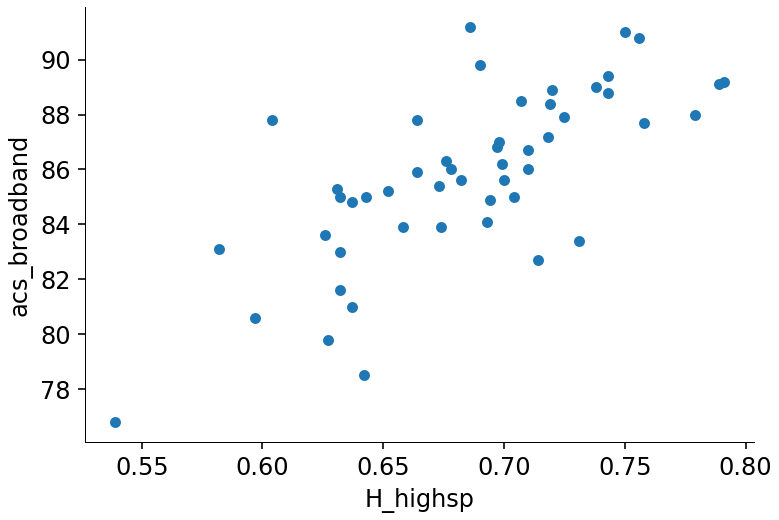

In [18]:
acs_cps_state.plot(kind = "scatter", x = "H_highsp", y = "acs_broadband")
acs_cps_state.corr().acs_broadband.sort_values(ascending = False)

So at the state level, the agreement is pretty good, but hardly perfect.  These are both numbers from 2019.

### Access Between Cities

In [19]:
city_access = access(cps_city.query("notGQ"), "city")
city_access.sort_values("H_highsp", ascending = False, inplace = True)
city_access = city_access[['H_at_home', 'H_mobdat', 'H_highsp', 
                           'P_anywhere', 'P_at_home', 'P_at_work',
                           'P_smartphone', 'P_computer', "cps_population"]]

city_access.style.background_gradient(cmap = "viridis", axis = 0).format(precision = 3)

,H_at_home,H_mobdat,H_highsp,P_anywhere,P_at_home,P_at_work,P_smartphone,P_computer,cps_population
city,,,,,,,,,
San Jose,0.897,0.853,0.861,0.871,0.853,0.500,0.800,0.743,712351.707
Austin,0.922,0.911,0.826,0.928,0.845,0.460,0.841,0.746,772743.135
Washington,0.853,0.822,0.795,0.873,0.825,0.497,0.767,0.712,674726.062
Dallas,0.901,0.889,0.788,0.843,0.783,0.376,0.821,0.527,949174.713
Seattle,0.871,0.820,0.783,0.918,0.831,0.565,0.768,0.720,724611.591
Denver,0.833,0.752,0.781,0.829,0.777,0.421,0.753,0.655,766922.591
Columbus,0.793,0.739,0.750,0.816,0.778,0.384,0.767,0.625,913920.005
San Diego,0.792,0.695,0.728,0.831,0.756,0.351,0.750,0.660,1276144.608
Charlotte,0.825,0.756,0.722,0.786,0.736,0.273,0.719,0.585,692284.960


The fact that SF is low feels really weird.

In [20]:
sf = cps.query("(gestfips == 6) & (gtcbsa == 41860) & (gtcbsast == 1) & (gtco == 75) & (gtindvpc == 1) & notGQ")
sf_internet = sf.query("(hehomte1 == 1) & isHouseholder & notGQ").hwhhwgt.sum() / sf.query("isHouseholder & notGQ").hwhhwgt.sum()

sf_internet

0.6138582386402205

Are the standard errors just enormous?  Follow the methods here: https://cps.ipums.org/cps/repwt.shtml#q40

In [21]:
hh               = sf.query("isHouseholder").filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()
hh_with_internet = sf.query("(H_highsp == 1) & isHouseholder").filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()

sf_internet_reps = hh_with_internet / hh

np.sqrt((4 / 160) * ((sf_internet_reps - sf_internet)**2).sum())

0.04994392482051794

It's big -- 5% -- but since California is at 80%, it's still 3σ!!

In [22]:
acs_place = get_acs_by_geog("place")
acs_place = acs_place.sort_values("acs_population", ascending = False).head(20).copy()
acs_place.index = acs_place.index.str.replace(" city.*", "", regex = True)

In [23]:
cps_vs_acs = city_access.join(acs_place)

city
San Jose         0.697163
Dallas           0.706460
Charlotte        0.781618
Austin           0.789107
Phoenix          0.862460
San Diego        0.896262
Houston          0.905817
San Francisco    0.906625
Chicago          0.907848
New York         0.948384
Washington       0.956043
Seattle          0.961463
Jacksonville     0.970680
Los Angeles      0.996380
Philadelphia     1.011742
Columbus         1.013133
Denver           1.054608
Indianapolis     1.065808
San Antonio      1.142029
Fort Worth       1.187761
Name: pop_ratio, dtype: float64

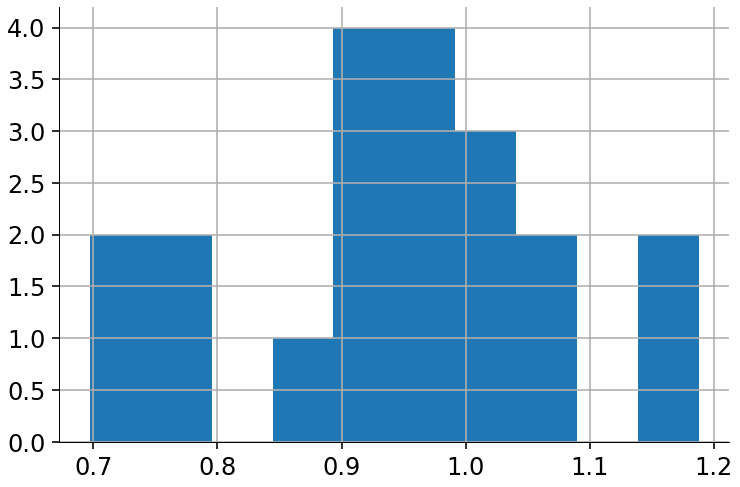

In [24]:
cps_vs_acs["pop_ratio"] = cps_vs_acs["cps_population"] / cps_vs_acs["acs_population"]
cps_vs_acs.pop_ratio.hist()
cps_vs_acs.pop_ratio.sort_values()

0.5609941970279922


,H_highsp,acs_broadband
city,,
Indianapolis,0.543,82.4
Chicago,0.600,83.6
San Francisco,0.614,89.7
Los Angeles,0.621,87.7
Houston,0.623,85.0
Philadelphia,0.638,84.2
Phoenix,0.651,84.9
San Antonio,0.667,83.1
Jacksonville,0.671,88.2


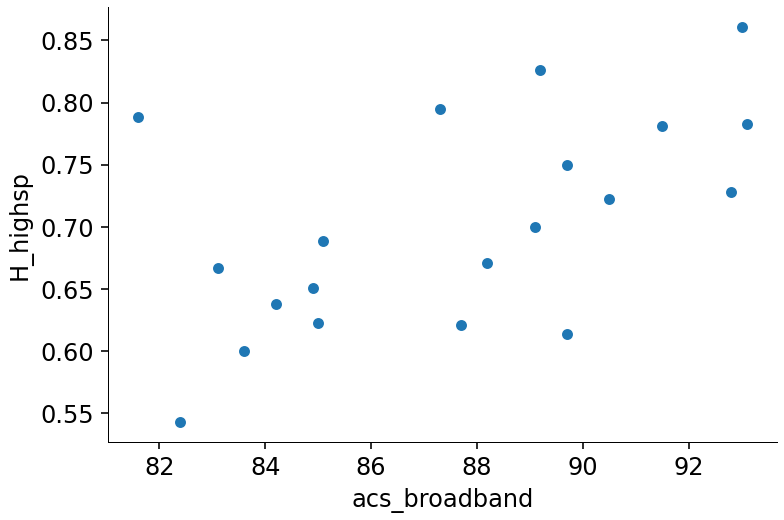

In [25]:
cps_vs_acs.plot(kind = "scatter", x = "acs_broadband", y = "H_highsp")
print(cps_vs_acs.corr()["H_highsp"]["acs_broadband"])

cps_vs_acs[["H_highsp", "acs_broadband"]].sort_values(by = "H_highsp")

### CBSA Estimates of Internet Access

In [26]:
cps_cbsa_agg = access(cps_cbsa.query("notGQ"), "cbsa")

cps_cbsa_agg = cps_cbsa_agg[['H_at_home', 'H_mobdat', 'H_highsp', 
                             'P_anywhere', 'P_at_home', 'P_at_work',
                             'P_smartphone', 'P_computer', "cps_population"]]

cps_cbsa_agg.sort_values("H_highsp", ascending = False, inplace = True)
cps_cbsa_agg.style.background_gradient(cmap = "viridis", axis = 0).format(precision = 3)

,H_at_home,H_mobdat,H_highsp,P_anywhere,P_at_home,P_at_work,P_smartphone,P_computer,cps_population
cbsa,,,,,,,,,
Dallas-Fort Worth,0.875,0.839,0.788,0.841,0.766,0.346,0.741,0.605,8025142.352
Washington,0.850,0.798,0.778,0.817,0.773,0.395,0.712,0.652,5913949.406
Denver,0.856,0.790,0.777,0.855,0.788,0.389,0.733,0.653,2831877.222
Tampa,0.783,0.603,0.746,0.785,0.718,0.319,0.659,0.601,2928313.477
Phoenix,0.838,0.789,0.742,0.823,0.783,0.321,0.730,0.626,4770675.689
Minneapolis,0.875,0.804,0.738,0.843,0.812,0.403,0.725,0.648,3397369.718
San Francisco,0.804,0.738,0.734,0.797,0.761,0.375,0.711,0.638,4559477.778
New York,0.787,0.717,0.731,0.780,0.729,0.312,0.680,0.577,19231686.446
Seattle,0.823,0.773,0.727,0.819,0.768,0.370,0.689,0.620,4012495.755


#### Get the "same" data from the Census.

In [27]:
acs_cbsa = get_acs_by_geog("metropolitan statistical area/micropolitan statistical area")

acs_cbsa.index = acs_cbsa.geoid.replace(cbsa_dict)
acs_cbsa = acs_cbsa.sort_values("acs_population", ascending = False).head(20).copy()

acs_cbsa.index = acs_cbsa.index.str.title().str.replace("_", " ")

And then join these together.

In [28]:
cps_acs_cbsa = cps_cbsa_agg.join(acs_cbsa)

Confirm that they at least agree on population counts.

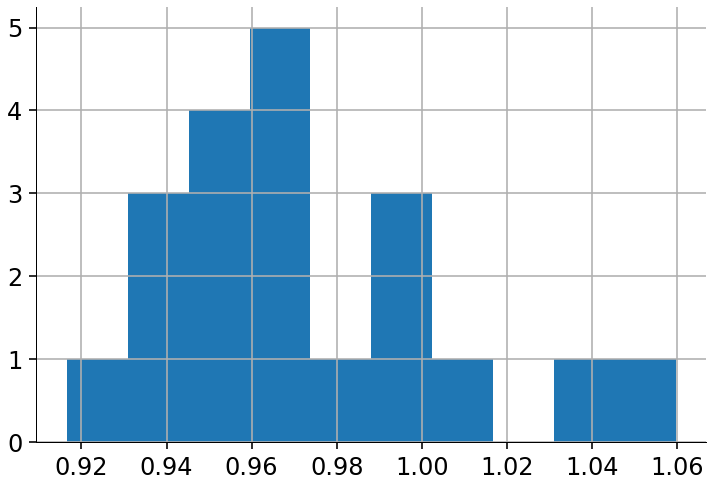

In [29]:
cps_acs_cbsa["pop_ratio"] = cps_acs_cbsa["cps_population"] / cps_acs_cbsa["acs_population"]
cps_acs_cbsa.pop_ratio.hist()

But the correlations are really terrible.

In [30]:
cps_acs_cbsa.corr().acs_broadband.sort_values(ascending = False)

acs_broadband     1.000000
P_at_work         0.563639
P_anywhere        0.480572
P_at_home         0.469295
P_computer        0.462822
P_smartphone      0.455118
H_at_home         0.416619
H_highsp          0.411669
H_mobdat          0.298020
geoid             0.218269
pop_ratio        -0.249597
acs_population   -0.321776
cps_population   -0.333660
Name: acs_broadband, dtype: float64

### The issue with San Francisco, in *very* short.

Now let's check in on CA and SF households.  We will contrast the calculated values with the official ones, and California generally with SF only.

In [31]:
cps_test = pd.read_csv("nov19-cps.csv.gz")

# Householders
cps_test["isHouseholder"] = (cps_test.perrp > 0) & (cps_test.perrp < 3) & \
                            (cps_test.hrhtype > 0) & (cps_test.hrhtype < 9)

# Households in California, and those in SF county/city.
ca_households = cps_test.query("(gestfips == 6) & isHouseholder")
sf_households = ca_households.query("gtco == 75")

# Get the "official" estimate and compare to our calculted quantity for CA, 
#   and then SF (no official available)
ca_ntia_official = 0.799
ca_internet = ca_households.query("heinhome == 1").hwhhwgt.sum() / ca_households.hwhhwgt.sum()
sf_internet = sf_households.query("heinhome == 1").hwhhwgt.sum() / sf_households.hwhhwgt.sum()

ca_ntia_official, ca_internet, sf_internet

(0.799, 0.7992982448757221, 0.6540205571069156)

Are the errors just enormous??

In [32]:
hh               = sf_households.filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()
hh_with_internet = sf_households.query("heinhome == 1").filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()

sf_internet_reps = hh_with_internet / hh

np.sqrt((4 / 160) * ((sf_internet_reps - sf_internet)**2).sum())

0.04973236508815024

So I exactly reproduce the "correct" answer, but SF county shows up as quite significantly lower internet use at home than the rest of CA.

For certain variables, like Internet at home, SF is as much as 3 standard deviations lower than the CA value.

This simply does not feel correct to me.